In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta

In [23]:
HAP_df = pd.read_parquet('data/pricing_data/avgHighPrice.parquet.gzip')
LAP_df = pd.read_parquet('data/pricing_data/avgLowPrice.parquet.gzip')
HAV_df = pd.read_parquet('data/pricing_data/highPriceVolume.parquet.gzip')
LAV_df = pd.read_parquet('data/pricing_data/lowPriceVolume.parquet.gzip')

In [8]:
with open("data/name_dicts/ID_to_name.json","r") as f:
    id2name=json.load(f)
with open("data/name_dicts/name_to_ID.json","r") as f:
    name2id=json.load(f)

In [24]:
HAV_df = HAV_df.fillna(0)
LAV_df = LAV_df.fillna(0)

In [25]:
HAP_df = HAP_df.interpolate(method = "linear")
LAP_df = LAP_df.interpolate(method = "linear")

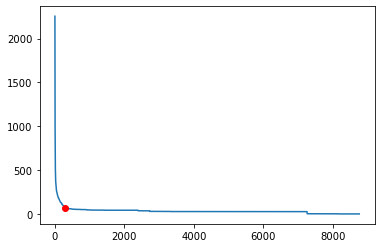

In [247]:
plt.plot(HAP_df.index.tolist(), HAP_df.isnull().sum(axis=1).tolist() )
plt.plot(HAP_df.index.tolist()[300],HAP_df.isnull().sum(axis=1).tolist()[300], "o", color = "r")
plt.show()

In [11]:
HAP_df = HAP_df.iloc[300: , :]
LAP_df = LAP_df.iloc[300: , :]
HAV_df = HAV_df.iloc[300: , :]
LAV_df = LAV_df.iloc[300: , :]

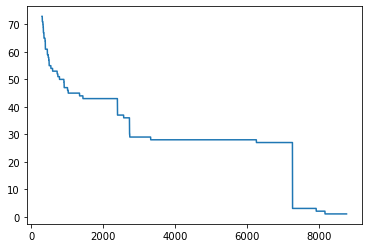

In [249]:
plt.plot(HAP_df.index.tolist(), HAP_df.isnull().sum(axis=1).tolist() )

plt.show()

In [12]:
cols = []
for col in HAP_df.columns:
    if HAP_df[col].isnull().any() == False and LAP_df[col].isnull().any() == False:
        cols.append(col)
len(cols)

3724

In [13]:
HAP_df = HAP_df[cols]
LAP_df = LAP_df[cols]
HAV_df = HAV_df[cols]
LAV_df = LAV_df[cols]

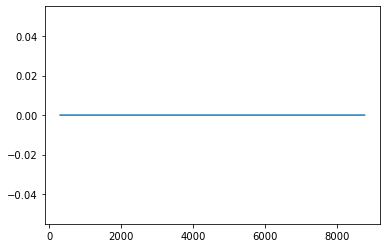

In [252]:
plt.plot(HAP_df.index.tolist(), HAP_df.isnull().sum(axis=1).tolist() )

plt.show()

In [257]:
window_size = 60 #how far in the past we give our model
future_size = 2 #how far in the future we ask it to predict. 

In [26]:
dfs = [HAP_df,LAP_df, HAV_df,LAV_df]
arrays = [df.values for df in dfs]
data = np.stack(arrays, axis =0)
data.shape
#(metric, time, item)

(4, 8762, 3797)

In [55]:
temp_list = []
temp_list.append(generate_roc)
temp_list.append(generate_roc)
temp_check = pd.DataFrame(np.vstack(temp_list).T)

In [63]:
#  Adding differencing, rate of change
#  First value is always Na because no change from first one
temp_list = []
for i in range(data.shape[2]):
    feature_roc = ta.momentum.ROCIndicator(close = pd.Series(data[0,:,i]), window = 1)
    generate_roc = feature_roc.roc()
    temp_list.append(generate_roc)
ROC_df = pd.DataFrame(np.vstack(temp_list).T)


In [64]:
# Binning and Rate of Change, Bin size = bin_size
# First bin_size values are Na, rate of change calculated over average value over bin_size time stamps
bin_size = 10
temp_list = []
for i in range(data.shape[2]):
    feature_roc = ta.momentum.ROCIndicator(close = pd.Series(data[0,:,i]), window = bin_size)
    generate_roc = feature_roc.roc()
    temp_list.append(generate_roc)
ROC_bin_df = pd.DataFrame(np.vstack(temp_list).T)


In [70]:
# Moving Average for bins
temp_list = []
for i in range(data.shape[2]):
    feature_MA = ta.trend.SMAIndicator(close = pd.Series(data[0,:,i]), window = bin_size)
    generate_MA = feature_MA.sma_indicator()
    temp_list.append(generate_MA)
MA_df = pd.DataFrame(np.vstack(temp_list).T)

In [68]:
# Ease of movement
temp_list = []
for i in range(data.shape[2]):
    feature_EOM = ta.volume.EaseOfMovementIndicator(high= pd.Series(data[0,:,i]), low = pd.Series(data[1,:,i]), volume=pd.Series(data[2,:,i]))
    generate_EOM = feature_EOM.ease_of_movement()
    temp_list.append(generate_EOM)
EOM_df = pd.DataFrame(np.vstack(temp_list).T)

In [69]:
# Ulcer index for volatility https://school.stockcharts.com/doku.php?id=technical_indicators:ulcer_index
# Will use same bin size as the ROC with binning
# Takes a while to compute, could skip this
temp_list = []
for i in range(data.shape[2]):
    feature_Volatility = ta.volatility.UlcerIndex(close = pd.Series(data[0,:,i]), window = bin_size)
    generate_Volatility = feature_Volatility.ulcer_index()
    temp_list.append(generate_Volatility)
Volatility_df = pd.DataFrame(np.vstack(temp_list).T)

KeyboardInterrupt: 

In [74]:
# Adding Mass index, also a volatility indicator tracks change in trend
# https://www.investopedia.com/terms/m/mass-index.asp#:~:text=Mass%20index%20is%20a%20form,certain%20point%20and%20then%20contracts.
temp_list = []
for i in range(data.shape[2]):
    feature_MI = ta.trend.mass_index(high= pd.Series(data[0,:,i]), low = pd.Series(data[1,:,i]), fillna = True)
    temp_list.append(feature_MI)
MI_df = pd.DataFrame(np.vstack(temp_list).T)

In [267]:
observations =[]
values = []
for i in range(window_size,len(HAP_df)-future_size):
    X_indices = list(range(i-window_size,i))
    y_indices = list(range(i, i+future_size))
    observations.append(data[:,X_indices,:])
    values.append(data[:,y_indices,:])

In [268]:
X = np.stack(observations,axis = 0)

In [269]:
X.shape
#observation, metrics, time, item

(8400, 4, 60, 3724)

In [270]:
y = np.stack(values, axis = 0)
y.shape

(8400, 4, 2, 3724)

In [ ]:
def get_data(data_path, window_size, future_size):
    HAP_df = pd.read_parquet(f'{data_path}/pricing_data/avgHighPrice.parquet.gzip')
    LAP_df = pd.read_parquet(f'{data_path}/pricing_data/avgLowPrice.parquet.gzip')
    HAV_df = pd.read_parquet(f'{data_path}/pricing_data/highPriceVolume.parquet.gzip')
    LAV_df = pd.read_parquet(f'{data_path}/pricing_data/lowPriceVolume.parquet.gzip')
    
    HAV_df = HAV_df.fillna(0)
    LAV_df = LAV_df.fillna(0)
   
    HAP_df = HAP_df.interpolate(method = "linear")
    LAP_df = LAP_df.interpolate(method = "linear")
    
    HAP_df = HAP_df.iloc[300: , :]
    LAP_df = LAP_df.iloc[300: , :]
    HAV_df = HAV_df.iloc[300: , :]
    LAV_df = LAV_df.iloc[300: , :]
    
    dfs = [HAP_df,LAP_df, HAV_df,LAV_df]
    arrays = [df.values for df in dfs]
    data = np.stack(arrays, axis =0)
    #shape = (metric, time, item)
    
    observations =[]
    values = []
    for i in range(window_size,len(HAP_df)-future_size):
        X_indices = list(range(i-window_size,i))
        y_indices = list(range(i, i+future_size))
        observations.append(data[:,X_indices,:])
        values.append(data[:,y_indices,:])
    
    X = np.stack(observations,axis = 0)
    y = np.stack(values, axis = 0)
    #X_shape = observation, metrics, time, item
    return X,y